In [1]:
import json
from dataclasses import dataclass
from pathlib import Path
from abc import abstractmethod, ABC
from typing import Iterable
from enum import StrEnum

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


In [2]:
BASE_PATH = Path("../results")

def get_result_path(algorithm: str, instance: str) -> Path:
    filename = f"{instance}_{algorithm}_results.json"
    return BASE_PATH / algorithm / filename

def get_summary_path(algorithm: str, instance: str) -> Path:
    filename = f"{instance}_summary.json"
    return BASE_PATH / algorithm / filename

@dataclass
class Result:
    objective_value: int
    path_length: int
    node_costs: int
    computation_time_ms: int
    selected_nodes_count: int
    total_nodes: int
    solution_route: list[int]
    edges: set[tuple[int, int]] = None
    reversed_edges: set[tuple[int, int]] = None
    nodes: set[int] = None
    instance: str = None
    algorithm: str = None

    def fill_edges_and_nodes(self):
        if self.solution_route is not None:
            self.edges = set()
            self.reversed_edges = set()
            for i in range(len(self.solution_route)):
                a = self.solution_route[i]
                b = self.solution_route[(i + 1) % len(self.solution_route)]
                self.edges.add((a, b))
                self.reversed_edges.add((b, a))
            self.nodes = set(self.solution_route)

    @classmethod
    def from_summary_dict(cls, key: str, data: dict, instance: str = None) -> "Result":
        """
        Parse a summary dictionary entry into a Result object.
        
        Example input:
            key: "LNS_d-0.40_RANDOM_REMOVAL_ls-Off_hood-TWO_OPT"
            data: {
                "total_runs": 20,
                "avg_time_ms": 5782.3,
                "max_objective": 70554.0,
                "best_solution_validated": true,
                "best_solution_nodes": [...],
                "min_objective": 69255.0,
                "avg_objective": 69737.15
            }
        """
        solution_nodes = data.get("best_solution_nodes", [])
        result = cls(
            objective_value=int(data.get("min_objective", 0)),
            path_length=0,  # Not available in summary format
            node_costs=0,   # Not available in summary format
            computation_time_ms=int(data.get("avg_time_ms", 0)),
            selected_nodes_count=len(solution_nodes),
            total_nodes=0,  # Not available in summary format
            solution_route=solution_nodes,
            instance=instance,
            algorithm=key,
        )
        result.fill_edges_and_nodes()
        return result
    
    @classmethod
    def load_summary(cls, file_path: str | Path) -> list["Result"]:
        with open(file_path, 'r') as f:
            data = json.load(f)
        instance = "TSPA" if "TSPA" in file_path.name else "TSPB"
        results = []
        for key, entry in data["algorithm_statistics"].items():
            result = Result.from_summary_dict(
                key,
                entry,
                instance=instance
            )
            result.fill_edges_and_nodes()
            results.append(result)
        return results


def load_results(file_path: str | Path) -> list[Result]:
    with open(file_path, 'r') as f:
        data = json.load(f)["results"]
    results = [Result(**item) for item in data]
    for result in results:
        result.fill_edges_and_nodes()
    return results

In [3]:
class SimilarityMetric(ABC):
    @abstractmethod
    def calculate(self, result_1: Result, result_2: Result) -> float:
        pass

    def __call__(self, result_1: Result, results: Result | Iterable[Result]) -> float:
        if isinstance(results, Result):
            results = [results]
        similarities = []
        for result in results:
            similarity = self.calculate(result_1, result)
            similarities.append(similarity)
        return sum(similarities) / len(similarities) if similarities else 0.0

class NodeSimilarity(SimilarityMetric):
    def calculate(self, result_1: Result, result_2: Result) -> float:
        if result_1.nodes is None or result_2.nodes is None:
            return 0.0
        intersection = result_1.nodes.intersection(result_2.nodes)
        return len(intersection) / max(len(result_1.nodes), len(result_2.nodes))
    
class EdgeSimilarity(SimilarityMetric):
    def calculate(self, result_1: Result, result_2: Result) -> float:
        if result_1.edges is None or result_2.edges is None:
            return 0.0
        intersection = result_1.edges.intersection(result_2.edges.union(result_2.reversed_edges))
        return len(intersection) / max(len(result_1.edges), len(result_2.edges))

In [4]:
def find_best_solution(results: list[Result]) -> Result:
    return min(results, key=lambda r: r.objective_value)

def find_2_best_solutions(results: list[Result]) -> tuple[Result, Result]:
    sorted_results = sorted(results, key=lambda r: r.objective_value)
    return sorted_results[0], sorted_results[1]

In [5]:
def objective_similarity_map(
    results: list[Result],
    similarity_metric: SimilarityMetric,
    best_solution: Result | None = None,
) -> dict[int, float]:
    similarity_map = {}
    for result in results:
        if result is best_solution:
            continue
        similarity = similarity_metric(result, best_solution or results)
        similarity_map[result.objective_value] = similarity
    return similarity_map

In [6]:
def plot_fitness_similarity_correlation(
    similarity_map: dict[int, float],
    title: str,
    xlabel: str = "Objective Function Value",
    ylabel: str = "Similarity",
    save_path: str | Path | None = None,
) -> float:
    """
    Plot fitness-similarity correlation chart and return the correlation coefficient.
    """
    objectives = list(similarity_map.keys())
    similarities = list(similarity_map.values())
    
    # Calculate correlation coefficient
    correlation, p_value = stats.pearsonr(objectives, similarities)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.scatter(objectives, similarities, alpha=0.5, s=20, edgecolors='none')
    
    # Add trend line
    z = np.polyfit(objectives, similarities, 1)
    p = np.poly1d(z)
    x_line = np.linspace(min(objectives), max(objectives), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label="Trend line")
    
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(f"{title}\nCorrelation: r = {correlation:.4f} (p = {p_value:.2e})", fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()
    
    return correlation


def generate_all_convexity_charts(
    results_instance_a: list[Result],
    results_instance_b: list[Result],
    best_external_a: Result | None = None,
    best_external_b: Result | None = None,
    save_dir: str | Path | None = None,
) -> dict[str, float]:
    """
    Generate all 12 charts for global convexity tests.
    
    Parameters:
    - results_instance_a: List of 1000 local optima for instance A
    - results_instance_b: List of 1000 local optima for instance B
    - best_external_a: Best solution from another method for instance A
    - best_external_b: Best solution from another method for instance B
    - save_dir: Directory to save charts (optional)
    
    Returns:
    - Dictionary of correlation coefficients for each chart
    """
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
    
    correlations = {}
    
    instances = {
        "TSPA": (results_instance_a, best_external_a),
        "TSPB": (results_instance_b, best_external_b),
    }
    
    similarity_metrics = {
        "Edge": EdgeSimilarity(),
        "Node": NodeSimilarity(),
    }
    
    for instance_name, (results, best_external) in instances.items():
        best_from_1000 = find_best_solution(results)
        
        for metric_name, metric in similarity_metrics.items():
            # 1. Average similarity to all other local optima (best_solution=None)
            sim_map = objective_similarity_map(results, metric, best_solution=None)
            title = f"{instance_name} - Average {metric_name} Similarity to All Local Optima"
            save_path = save_dir / f"{instance_name}_avg_{metric_name.lower()}_similarity.png" if save_dir else None
            corr = plot_fitness_similarity_correlation(
                sim_map, title,
                ylabel=f"Average {metric_name} Similarity",
                save_path=save_path
            )
            correlations[f"{instance_name}_avg_{metric_name}"] = corr
            
            # 2. Similarity to best out of 1000 local optima
            sim_map = objective_similarity_map(results, metric, best_solution=best_from_1000)
            title = f"{instance_name} - {metric_name} Similarity to Best Local Optimum\n(Best obj: {best_from_1000.objective_value})"
            save_path = save_dir / f"{instance_name}_best1000_{metric_name.lower()}_similarity.png" if save_dir else None
            corr = plot_fitness_similarity_correlation(
                sim_map, title,
                ylabel=f"{metric_name} Similarity to Best",
                save_path=save_path
            )
            correlations[f"{instance_name}_best1000_{metric_name}"] = corr
            
            # 3. Similarity to best solution from another method
            if best_external:
                sim_map = objective_similarity_map(results, metric, best_solution=best_external)
                title = f"{instance_name} - {metric_name} Similarity to External Best Solution\n(External best obj: {best_external.objective_value})"
                save_path = save_dir / f"{instance_name}_external_{metric_name.lower()}_similarity.png" if save_dir else None
                corr = plot_fitness_similarity_correlation(
                    sim_map, title,
                    ylabel=f"{metric_name} Similarity to External Best",
                    save_path=save_path
                )
                correlations[f"{instance_name}_external_{metric_name}"] = corr
    
    return correlations


def print_correlation_summary(correlations: dict[str, float]):
    """Print a summary table of all correlation coefficients."""
    print("\n" + "=" * 60)
    print("CORRELATION COEFFICIENT SUMMARY")
    print("=" * 60)
    print(f"{'Chart Description':<45} {'Correlation':>12}")
    print("-" * 60)
    for key, value in correlations.items():
        print(f"{key:<45} {value:>12.4f}")
    print("=" * 60)

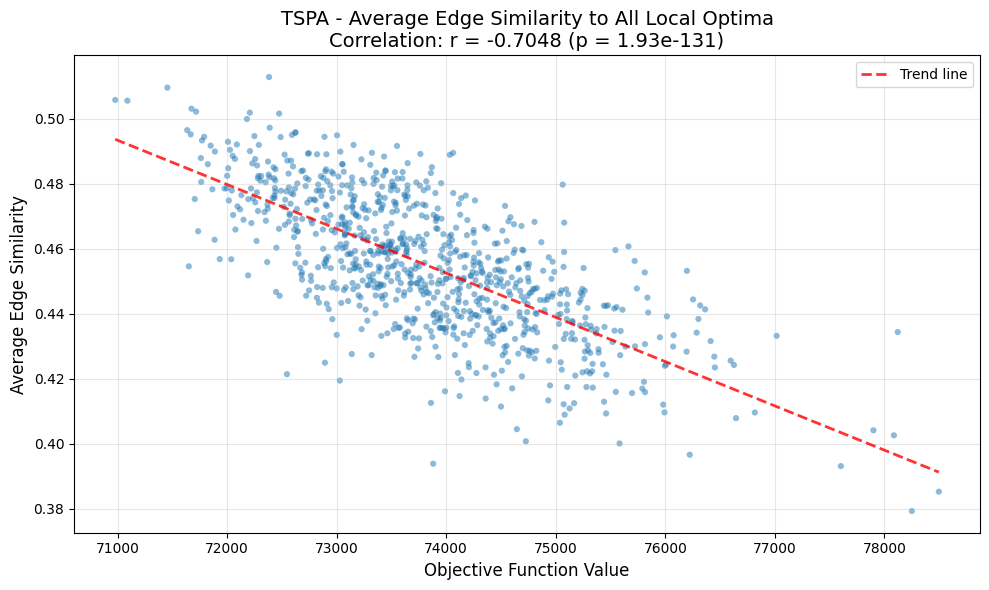

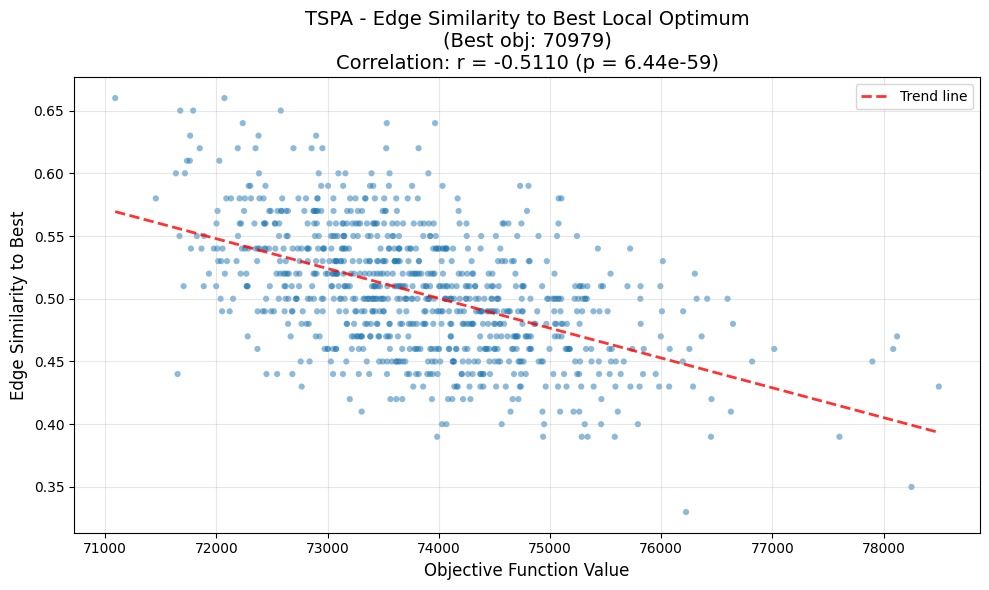

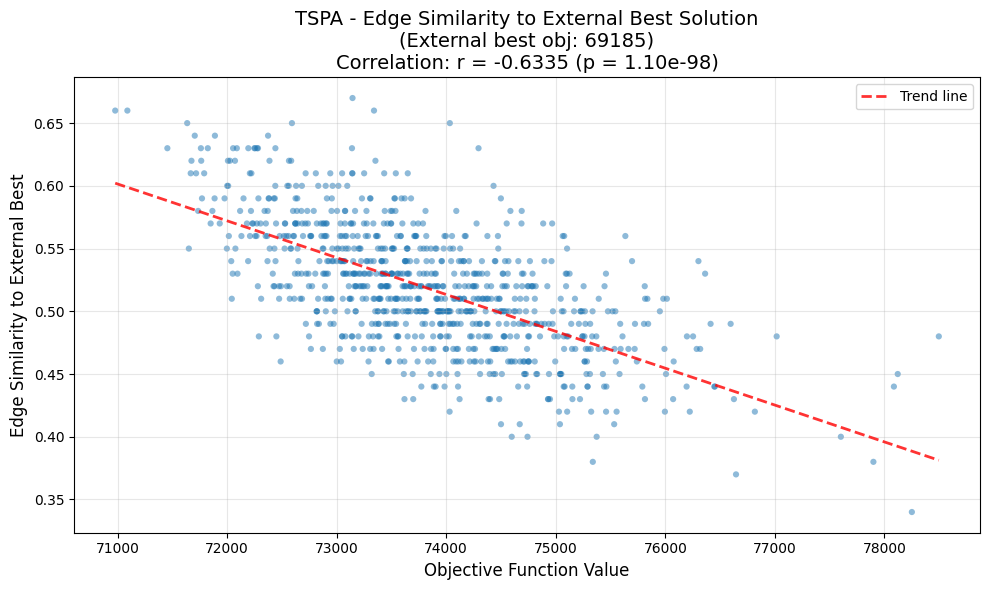

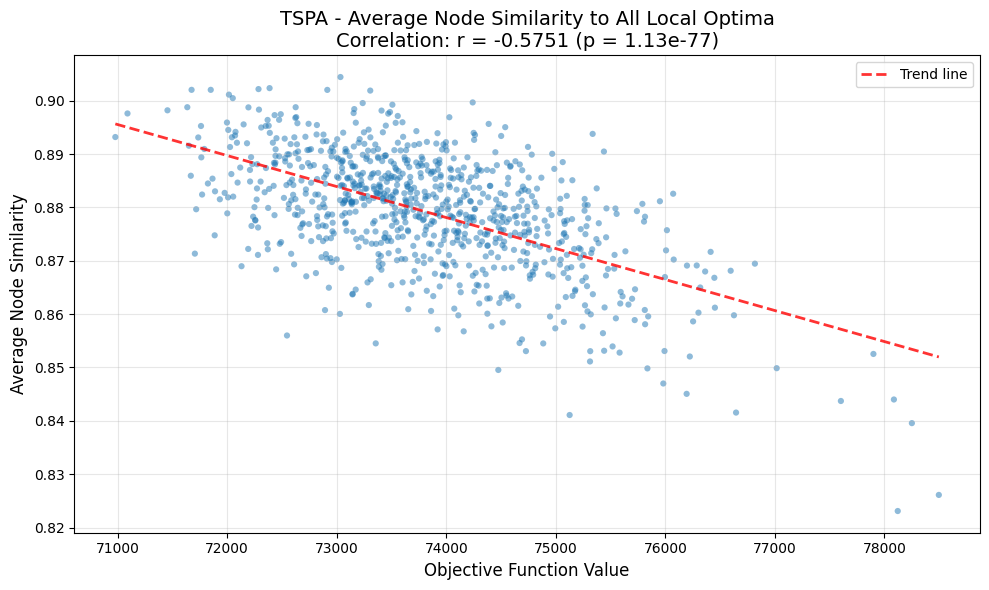

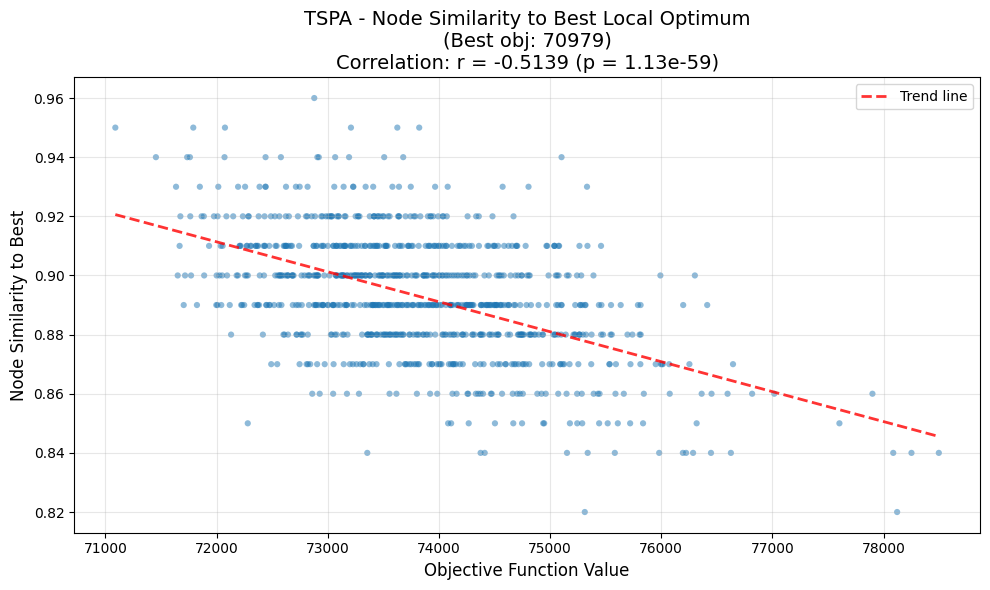

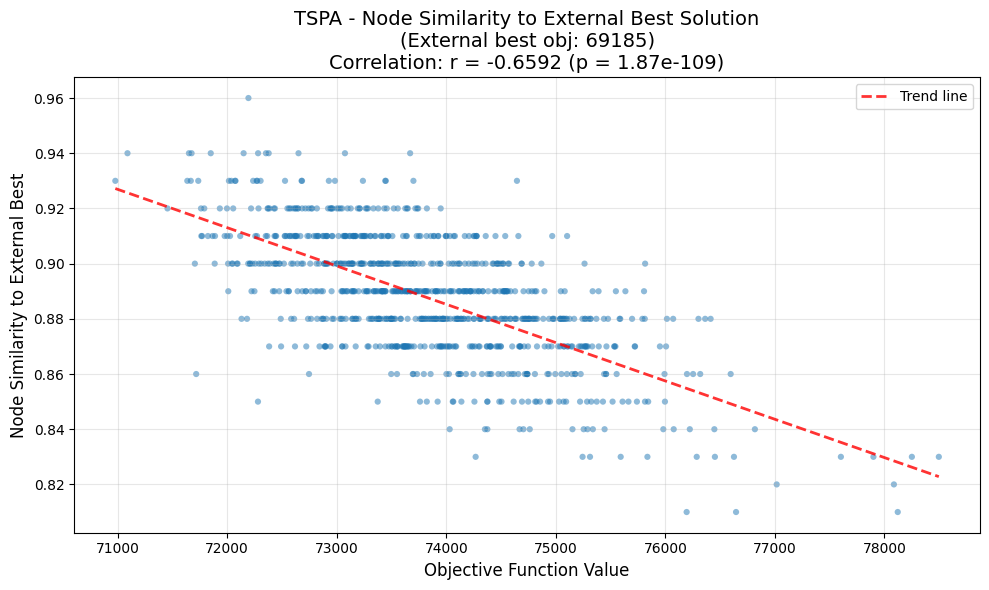

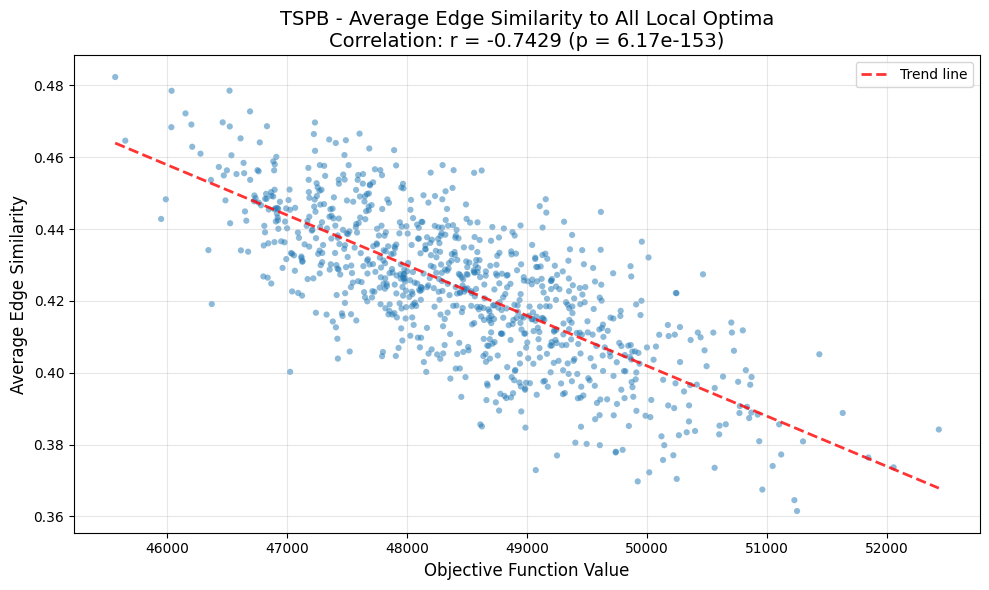

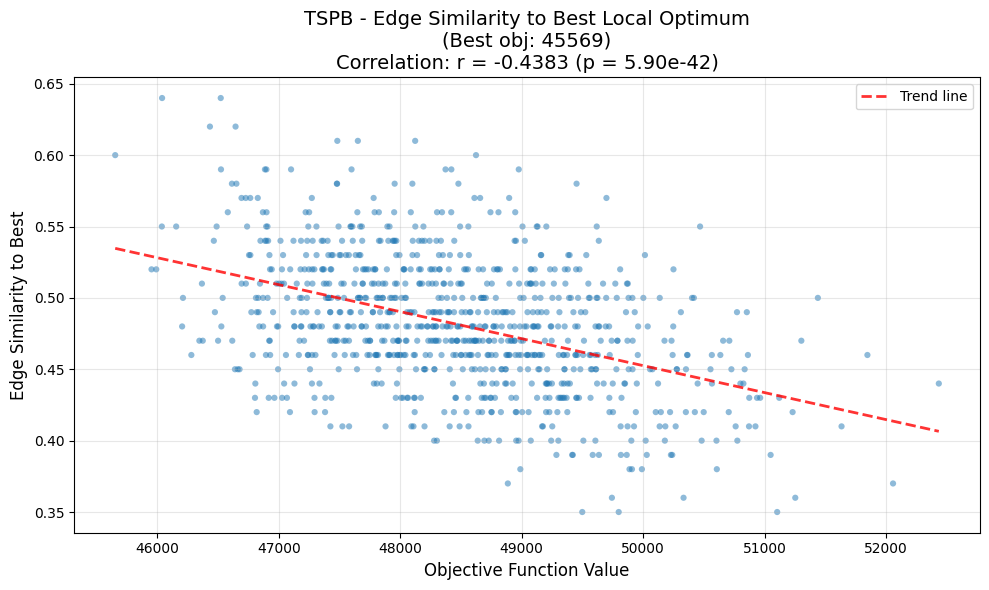

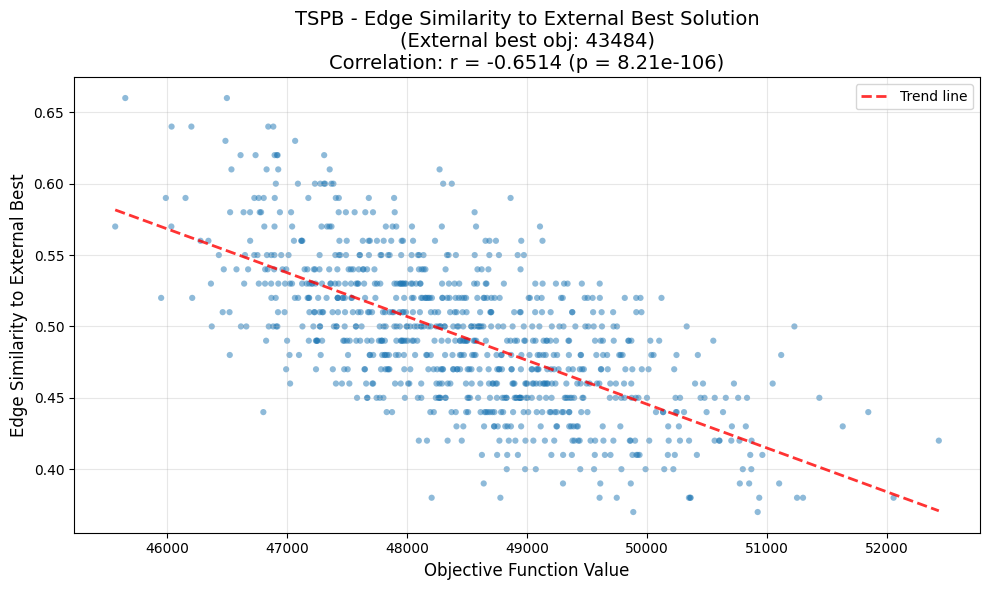

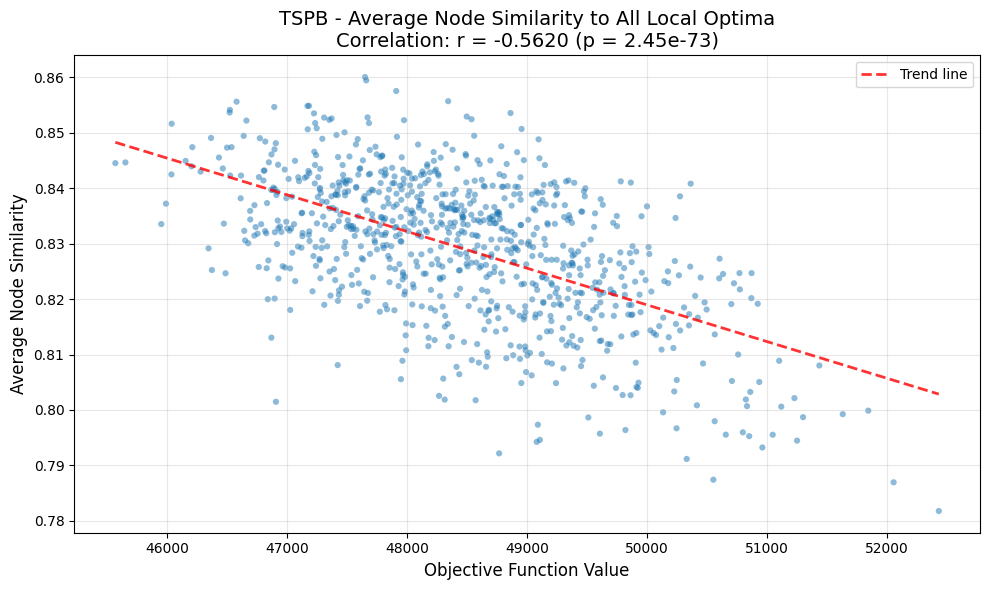

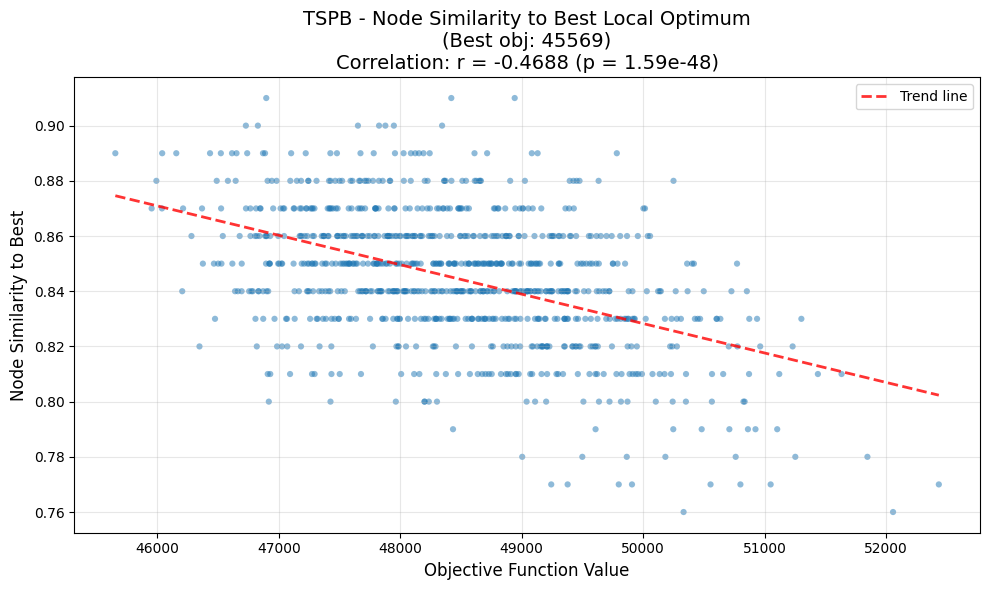

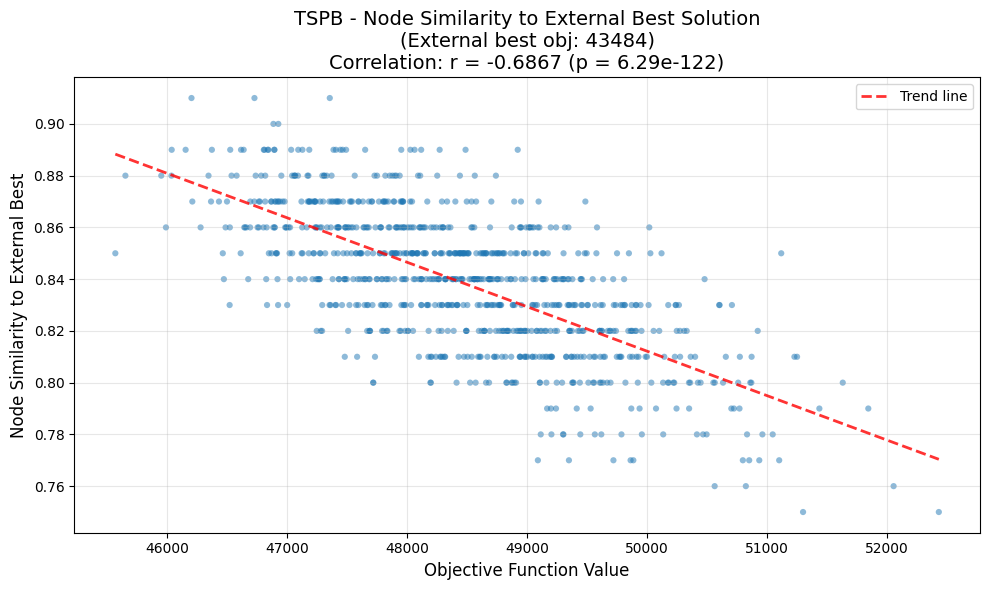


CORRELATION COEFFICIENT SUMMARY
Chart Description                              Correlation
------------------------------------------------------------
TSPA_avg_Edge                                      -0.7048
TSPA_best1000_Edge                                 -0.5110
TSPA_external_Edge                                 -0.6335
TSPA_avg_Node                                      -0.5751
TSPA_best1000_Node                                 -0.5139
TSPA_external_Node                                 -0.6592
TSPB_avg_Edge                                      -0.7429
TSPB_best1000_Edge                                 -0.4383
TSPB_external_Edge                                 -0.6514
TSPB_avg_Node                                      -0.5620
TSPB_best1000_Node                                 -0.4688
TSPB_external_Node                                 -0.6867


In [7]:

results_a = load_results(get_result_path("local_search", "TSPA"))
results_b = load_results(get_result_path("local_search", "TSPB"))

best_external_a = find_best_solution(Result.load_summary(get_summary_path("lns", "TSPA")))
best_external_b = find_best_solution(Result.load_summary(get_summary_path("lns", "TSPB")))

correlations = generate_all_convexity_charts(
    results_a, 
    results_b,
    best_external_a=best_external_a,
    best_external_b=best_external_b,
    save_dir="lab8/images/convexity"
)

print_correlation_summary(correlations)